## Rebuild the parametrized circuit in AWS Braket

In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector, Parameter
from qiskit.primitives import BackendEstimator, Estimator, Sampler, BackendSampler
from qiskit.quantum_info import SparsePauliOp

from braket.aws import AwsDevice, AwsSession

from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, QubitSet, AngledGate, Observable, noises, Noise
from braket.circuits.noise_model import GateCriteria, NoiseModel, NoiseModelInstruction
from braket.circuits.gates import X, Y, Z, Rx, Rz, CNot, XY, PulseGate, U, XX, ZZ
from braket.quantum_information import PauliString
from braket.parametric import FreeParameter, FreeParameterExpression
from braket.circuits.observables import TensorProduct

from qiskit_braket_provider.providers import adapter
from qiskit_braket_provider import AWSBraketProvider


In [2]:
# import numpy as np
# import sys
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
# module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# # from template_configurations import gate_q_env_config
# # from quantumenvironment import QuantumEnvironment
# # from gymnasium.wrappers import RescaleAction, ClipAction

# import logging
# logging.basicConfig(
#     level=logging.WARNING,
#     format="%(asctime)s INFO %(message)s", # hardcoded INFO level
#     datefmt="%Y-%m-%d %H:%M:%S",
#     stream=sys.stdout,
# )

# from aws_estimator import AWSEstimator

In [3]:
action_vector = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

Qiskit implementation of ``parametrized_circuit``

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


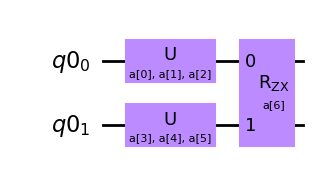

In [4]:
q_reg = QuantumRegister(2)
baseline = np.pi * np.zeros(len(action_vector))
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
# optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])
qiskit_circuit.draw("mpl")

Conversion of Qiskit circuit to Braket circuit

In [5]:
braket_circuit_converted = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)

print(braket_circuit_converted)

T  : |       0        |1|2|   3   |4|5|
                                       
q0 : -U(a_0, a_1, a_2)---C---------C---
                         |         |   
q1 : -U(a_3, a_4, a_5)-H-X-Rz(a_6)-X-H-

T  : |       0        |1|2|   3   |4|5|

Unassigned parameters: [a_0, a_1, a_2, a_3, a_4, a_5, a_6].


In [6]:
braket_circuit_converted.parameters

{a_0, a_1, a_2, a_3, a_4, a_5, a_6}

### AWSEstimator

In [7]:
from typing import List, Union, Optional

In [8]:
from typing import Union, Optional
import numpy as np

from braket.circuits import Circuit, Observable
from braket.circuits.observables import TensorProduct
from braket.quantum_information import PauliString


class BraketEstimator:
    def __init__(self, backend):
        self.backend = backend

    def _validate_inputs(self, circuit, bound_parameters):
        """
        Validate the inputs to ensure the number of circuits matches the number of bound_parameters.

        :param circuit: A single QuantumCircuit or a list of QuantumCircuits.
        :param bound_parameters: A single dictionary of parameters or a list of dictionaries.
        :raises ValueError: If the number of circuits and parameter dictionaries do not match.
        """
        # Check if inputs are lists; if not, wrap them in a list
        if not isinstance(circuit, list):
            circuit = [circuit]
        
        # Check if the number of circuits matches the number of parameter dictionaries
        if bound_parameters:
            if not isinstance(bound_parameters, list):
                bound_parameters = [bound_parameters]
            if len(circuit) != len(bound_parameters):
                raise ValueError("The number of circuits must match the number of dictionaries of bound parameters.")
        
    def _validate_observable_string(self, obs_str: str):
        """
        Validate the input string for the observable.

        :param obs_str: The input string for the observable.
        :raises ValueError: If the input string is not a valid Pauli string.
        """
        if not all(char in ["X", "Y", "Z", "I"] for char in obs_str):
            raise ValueError("The observable string must be a valid Pauli string. Use only 'X', 'Y', 'Z', and 'I' characters.")

        
    def _post_process(self, result, observables, coefficients=None):
        """
        Process the result from the quantum computation to extract and optionally scale the expectation values.

        :param result: The result object returned by the quantum computation.
        :param observables: A list of observables for which the expectation values were measured.
        :param coefficients: Optional list of coefficients to scale the expectation values of the observables.
                            This should be in the same order as the observables list.
        :return: A list of processed expectation values.
        """
        if not isinstance(result, list):
            expectation_values = []

            # If coefficients are provided, they must match the number of observables
            if coefficients and len([observables]) != len([coefficients]):
                raise ValueError("The number of coefficients must match the number of observables.")

            for i, observable in enumerate([observables]):
                # Extract the raw expectation value from the result object
                raw_expectation_value = result.values[i]  # Assuming result.values is a list of expectation values
            
                # Apply the coefficient if provided, else use the raw value
                if coefficients:
                    coefficients = [coefficients] if not isinstance(coefficients, list) else coefficients   
                    processed_value = coefficients[i] * raw_expectation_value
                else:
                    processed_value = raw_expectation_value

                # Ensure processed_value is a float, not an array
                if isinstance(processed_value, np.ndarray) and processed_value.size == 1:
                    processed_value = float(processed_value)
                elif isinstance(processed_value, (list, tuple)) and len(processed_value) == 1:
                    processed_value = float(processed_value[0])

                expectation_values.append(processed_value)

            return expectation_values
        
        elif isinstance(result, list) and len(result) > 1: # Result is a list
            expectation_values = []
            for res in result:
                expectation_values.append(self._post_process(res, observables, coefficients))
            return np.array(expectation_values).flatten()
        
    def _hamiltonian_post_process(self, result, coefficients=None):
        """
        Calculate the weighted sum of the expectation values.
        """
        if coefficients is None:
            coefficients = [1.0] * len(result.values)

        # Calculate the weighted sum of the expectation values
        total_expectation = sum(coeff * result.values[0] for coeff, result in zip(coefficients, result))
        return total_expectation
    
    @staticmethod
    def _commutator(op1, op2):
        return op1@op2 == op2@op1
    
    def _group_observables(self, observables):
        groups = []
        # print('Observables', observables)
        for obs in observables:
            # print('Observable', obs)
            if isinstance(obs, str):
                    self._validate_observable_string(obs)
                    obs = PauliString(obs).to_unsigned_observable(include_trivial=True)
            placed = False
            for group in groups:
                if all(self._commutator(obs, member) for member in group):
                    group.append(obs)
                    placed = True
                    break
            if not placed:
                groups.append([obs])
        return groups
    
    def _measure_hamiltonian(self, circuit, observables, target_register, bound_parameters, shots):

        observable = [tup[0] for tup in observables]
        coefficients = [tup[1] for tup in observables]
        # Group observables to minimize the number of circuits
        observable_groups = self._group_observables(observables=observable)
                    
        hamiltonian_results = []
        for group in observable_groups:
            # Make a copy of the original circuit for each group
            circ = circuit.copy() if isinstance(circuit, Circuit) else [c.copy() for c in circuit]

            for obs in group:
                # Convert string observables to the Observable type if necessary
                if not isinstance(obs, str) and not isinstance(obs, Observable) and not isinstance(obs, TensorProduct):
                    raise ValueError("Passed Observables can only be of type str, Observable or TensorProduct.")
                if isinstance(obs, str):
                    self._validate_observable_string(obs)
                    obs = PauliString(obs).to_unsigned_observable(include_trivial=True)

                # Use a dummy variable to avoid modifying the original circuit
                # Add the expectation instruction to the circuit for each observable
                circ = circuit.copy() if isinstance(circuit, Circuit) else [c.copy() for c in circuit]
                circ.expectation(observable=obs, target=target_register)

                if circuit.parameters: # Run with bound parameters if they exist
                    job = self.backend.run(circ, inputs=bound_parameters, shots=shots)
                else:
                    job = self.backend.run(circ, shots=shots)

                hamiltonian_results.append(job.result())

        hamiltonian_expval = self._hamiltonian_post_process(hamiltonian_results, coefficients)
        return hamiltonian_expval
    

    def run(
        self, 
        circuit: Union[Circuit, list[Circuit]], 
        observables: Union[list[tuple], list[Observable]] = None,
        target_register: Union[int, list[int]] = None,
        bound_parameters: Optional[dict] = None,
        shots: int = 0, 
    ):

        self._validate_inputs(circuit, bound_parameters)

        if isinstance(circuit, list) and len(circuit) > 1:

            if isinstance(observables, list) and len(observables) > 1: # Measure a Hamiltonian expression for multiple circuits
                hamiltonian_results = []
                for idx, circ in enumerate(circuit):
                    if bound_parameters:
                        expval = self._measure_hamiltonian(circ, observables[idx], target_register[idx], bound_parameters[idx], shots)
                    else:
                        expval = self._measure_hamiltonian(circ, observables[idx], target_register[idx], None, shots)
                    hamiltonian_results.append(expval)
                return np.array(hamiltonian_results)

            else: # Measure a a single operator / Pauli operator for multiple circuits
                print('Prepare to start running batch...')
                # The observables arrive as a list of tuples: [(observable, coefficient), ...]
                observable = observables[0][0]
                coefficient = observables[0][1]
                if isinstance(observable, str):
                    self._validate_observable_string(observable)
                    observable = PauliString(observable).to_unsigned_observable(include_trivial=True)
                for circ in circuit:
                    circ.expectation(observable=observable, target=target_register)
                
                print('Running batch...')
                job = self.backend.run_batch(circuit, inputs=bound_parameters, shots=shots)
                print('Finished running batch.')
                
                return self._post_process(list(job.results()), observable, coefficient)
        
        else: # Evaluate a single circuit
            circuit = circuit[0] if isinstance(circuit, list) else circuit

            if isinstance(observables, list) and len(observables) > 1: # Measure a Hamiltonian expression for a single circuit
                if bound_parameters:
                    hamiltonian_expval = self._measure_hamiltonian(circuit, observables, target_register, bound_parameters, shots)
                else:
                    hamiltonian_expval = self._measure_hamiltonian(circuit, observables, target_register, None, shots)
                return np.array(hamiltonian_expval)

            else: # Measure a single circuit for a single observable
                observable, coefficient = observables[0][0], observables[0][1]
                bound_parameters = bound_parameters if bound_parameters else None
                if isinstance(observable, str):
                    self._validate_observable_string(observable)
                    observable = PauliString(observable).to_unsigned_observable(include_trivial=True)
                circuit.expectation(observable=observable, target=target_register)
                
                if circuit.parameters:    
                    job = self.backend.run(circuit, inputs=bound_parameters, shots=shots)
                else:
                    job = self.backend.run(circuit, shots=shots)

                return self._post_process(job.result(), observables, coefficient)

Reconstruct the error-causing configuration of the CNOT calibration

In [9]:
param_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6']
# bound_parameters = dict(zip(param_names, action_vector))

batchsize = 50
bound_parameters = []
for batch in range(batchsize):
    action_vector = np.random.uniform(-np.pi, np.pi, 7)
    bound_parameters.append(dict(zip(param_names, action_vector)))

observables = [
    ('II', 0.25), ('IZ', -0.25), ('XI', 0.25), ('XZ', -0.25)
]



In [79]:
device = LocalSimulator()

braket_estimator = BraketEstimator(device)
expvals = braket_estimator.run(
    circuit=[braket_circuit_converted] * batchsize,
    observables=[observables] * batchsize,
    target_register=[[0, 1]] * batchsize,
    bound_parameters=bound_parameters,
)

expvals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Test own ``AWSEstimator`` against the ``Estimator`` from Qiskit

In [ ]:
import unittest

class TestBraketEstimator(unittest.TestCase):
    def setUp(self):
        # Initialize BraketEstimator with a mock backend for testing
        self.backend = LocalSimulator()
        self.estimator = BraketEstimator(self.backend)
        self.qiskit_estimator = Estimator() # For comparison

    def test_single_circuit_single_observable(self):
        # Define a single circuit and observable
        circuit = [Circuit().h(0)]
        observable = [('X', 1.0)]
        result = self.estimator.run(circuit, observables=observable, target_register=[0])

        qiskit_circuit = QuantumCircuit(1)
        qiskit_circuit.h(0)
        qiskit_observables = SparsePauliOp.from_list(observable)
        qiskit_job = self.qiskit_estimator.run(qiskit_circuit, observables=qiskit_observables)

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)

    def test_single_circuit_multiple_observables(self):
        # Define a single circuit and multiple observables with coefficients
        circuit = [Circuit().h(0)]
        observables = [('X', 1.0), ('Y', 0.5)]
        result = self.estimator.run(circuit, observables=observables, target_register=[0])
        
        qiskit_circuit = QuantumCircuit(1)
        qiskit_circuit.h(0)
        qiskit_observables = SparsePauliOp.from_list(observables)
        qiskit_job = self.qiskit_estimator.run(qiskit_circuit, observables=qiskit_observables)

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)

    def test_multiple_circuits_single_observable(self):
        # Define multiple circuits and a single observable with coefficient
        circuits = [Circuit().h(0), Circuit().x(0)]
        observable = [('Z', 1.0)]
        result = self.estimator.run(circuits, observables=observable, target_register=[[0], [0]])
        
        qiskit_circuit_01 = QuantumCircuit(1)
        qiskit_circuit_01.h(0)
        qiskit_circuit_02 = QuantumCircuit(1)
        qiskit_circuit_02.x(0)
        qiskit_circuits= [qiskit_circuit_01, qiskit_circuit_02]
        qiskit_observables = SparsePauliOp.from_list(observable)
        qiskit_job = self.qiskit_estimator.run(qiskit_circuits, observables=[qiskit_observables]*len(qiskit_circuits))

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)

    def test_multiple_circuits_multiple_observables(self):
        # Define multiple circuits and multiple observables with coefficients
        circuits = [Circuit().h(0), Circuit().x(0)]
        observables = [[('X', 1.0), ('Y', 0.5)], [('Z', 0.8)]]
        result = self.estimator.run(circuits, observables=observables, target_register=[[0], [0]])
        
        qiskit_circuit_01 = QuantumCircuit(1)
        qiskit_circuit_01.h(0)
        qiskit_circuit_02 = QuantumCircuit(1)
        qiskit_circuit_02.x(0)
        qiskit_circuits= [qiskit_circuit_01, qiskit_circuit_02]
        qiskit_observable_0 = SparsePauliOp.from_list(observables[0])
        qiskit_observable_1 = SparsePauliOp.from_list(observables[1])
        qiskit_observables = [qiskit_observable_0, qiskit_observable_1]
        qiskit_job = self.qiskit_estimator.run(qiskit_circuits, observables=qiskit_observables)

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)
    
    def test_two_qubit_circuit(self):
        # Define a single circuit and observable
        circuit = [Circuit().h(0).cnot(0, 1)]
        observable = [('XX', 1.0)]
        result = self.estimator.run(circuit, observables=observable, target_register=[0, 1])
        
        qiskit_circuit = QuantumCircuit(2)
        qiskit_circuit.h(0)
        qiskit_circuit.cx(0, 1)
        qiskit_observables = SparsePauliOp.from_list(observable)
        qiskit_job = self.qiskit_estimator.run(qiskit_circuit, observables=qiskit_observables)

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)

    def test_two_qubit_circuit_multiple_observables(self):
        # Define a single circuit and multiple observables with coefficients
        circuit = [Circuit().h(0).cnot(0, 1)]
        observables = [('XX', 1.0), ('YY', 0.5)]
        result = self.estimator.run(circuit, observables=observables, target_register=[0, 1])

        qiskit_circuit = QuantumCircuit(2)
        qiskit_circuit.h(0)
        qiskit_circuit.cx(0, 1)
        qiskit_observables = SparsePauliOp.from_list(observables)
        qiskit_job = self.qiskit_estimator.run(qiskit_circuit, observables=qiskit_observables)

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)

    def test_parametric_circuit(self):
        # Define a parametric circuit and observable
        circuit = [Circuit().rx(0, FreeParameter("alpha"))]
        observable = [('X', 1.0), ('Y', 0.5)]
        result = self.estimator.run(circuit, observables=observable, target_register=[0], bound_parameters={'alpha': 0.5})
        
        qiskit_circuit = QuantumCircuit(1)
        qiskit_circuit.rx(Parameter('alpha'), 0)
        qiskit_observables = SparsePauliOp.from_list(observable)
        qiskit_job = self.qiskit_estimator.run(qiskit_circuit, observables=qiskit_observables, parameter_values=[0.5])

        assert np.allclose(result, qiskit_job.result().values, atol=1e-6)

In [ ]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

### Add a noise model to the circuit

In [ ]:
noise_model = NoiseModel().add_noise(Noise.TwoQubitDepolarizing(0.5), GateCriteria(Gate.CNot))
noise_model.to_dict()

In [ ]:
# Test a noise model on a simple Bell state circuit
bell_circ = Circuit().h(0).cnot(0, 1)
bell_circ.expectation(observable=Observable.Z() @ Observable.Z(), target=[0, 1])

result_no_noise = LocalSimulator().run(bell_circ, shots=1000).result()
result_noise = LocalSimulator('braket_dm', noise_model=noise_model).run(bell_circ, shots=1000).result()

print('No noise:', result_no_noise.measurement_counts, ', Expval operator: ', result_no_noise.values)
print('With noise:', result_noise.measurement_counts, ', Expval operator: ', result_noise.values)